In [1]:
from IPython.display import display
import math
# import lux
import pandas as pd
import numpy as np
from astropy.time import Time
from pandas.core.reshape.tile import cut
import PlanetPos as PP
from JdUtils import stelJD
from time import time
import re
import NaksUtils
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
import math

warnings.filterwarnings("ignore")

/Users/sunder/miniforge3/envs/tfmetal/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/sunder/miniforge3/envs/tfmetal/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/sunder/miniforge3/envs/tfmetal/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utcut1" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/sunder/miniforge3/envs/tfmetal/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/sunder/miniforge3/envs/tfmetal/lib/python3.9/site-packages/erfa/core.py:15

## Explore the duration between succesive Planet - Nakshatra interaction

In [2]:
# upper case the first character of a string
def ucfirst(s): return s[0].upper() + s[1:].lower()

def fetch_gruha_df(gruha='mars', num_years=100):
	csv = f"../datasets/{gruha}-600bce-to-500bce-daily.csv"
	try :
		mdf = pd.read_csv(csv)
	except FileNotFoundError:
		bce600 = stelJD(-600,1,1,0,0)
		pp = PP.PlanetPos()
		t0 = time()
		mdf = pd.DataFrame()
		step=365
		for y in range(0,num_years*step,step) :
			ydf = pd.concat([ pp.get_planet_pos(bce600 + x ).loc[[ucfirst(gruha)],['jd', 'date', 'elong']] for x in range(y,y+step) ])
			mdf = pd.concat([mdf,ydf])
			print (f'{y//365 :4d} -- {y:6d} {y+step:6d} -- {time()-t0 :.2f}  -- {ydf.shape} {mdf.shape}')
			if (y//365)%10 == 0 :display(mdf.head(2), mdf.tail(2))

		mdf.to_csv(csv)
		display(mdf.head(), mdf.tail())
	return mdf

#%
def plot_gruha_near_naks(gdf, gruha, threshold=120,naks_lon=213.6, tol=.8, limit=None):
	# tol =.8
	m1 = gdf[ [ (naks_lon-tol) < x < (naks_lon+tol) for x in gdf.elong ] ]
	# display(f'{gruha} {m1.shape}')
	m1['jdiff'] = m1.jd.diff().fillna(1)
	m1 = m1[m1.jdiff>threshold].reset_index()
	m1['jdiff'] = m1.jd.diff().fillna(1)
	if not limit is None: 
		# display(f'{gruha=} {limit=} {m1.shape}')
		m1 = m1.loc[0:int(limit*len(m1))]
		# display(f'{limit=} {m1.shape}')
	# display(f'{gruha=} {m1.shape}') ; display(m1)
	m1['year'] = m1.date.apply(lambda x: int(re.sub("......T.*","",x)))
	m1 = m1[m1.jdiff>1]
	m1['cycle_duration'] = m1.jdiff
	m1['cycle_duration_mean'] = m1.cycle_duration.mean()
	ax=m1.plot(x='jd', y=['cycle_duration_mean'], marker='o', markersize=0, color='orange')
	ax=m1.plot(x='jd', y=['cycle_duration'], marker='o',rot=90, grid=True, figsize=(25,5), legend=not None,ax=ax)
	# ax=m1.plot.bar(x='jd', y=['cycle_duration'], rot=90, grid=True, figsize=(25,5), legend=not None,ax=ax)
	# bar ploT jd vs cycle_duration


	ax.set_xticks(m1.jd)
	ax.set_xlabel('year')
	# ax.set_ylabel(f'days since \n {gruha} passed {naks_lon} longitude', fontsize=15)
	ax.set_ylabel(f'cycle duration in days', fontsize=15)
	# ax.set_xticklabels( [ f'{-600+x2//365}-{1+(x2%365)//31:02d}' for x in m1.jd for x2 in [int(x-m1.jd\[1])]] )
	ax.set_xticklabels([ re.sub("T.*","",d) + f"\n({j:.0f})" for d, j in zip(m1.date, m1.cycle_duration)], rotation=90 if len(m1)>7 else 0, fontsize=10) 
	# ax.set_title(f'Days between {ucfirst(gruha)} and {naks_lon} longitude; {threshold =} days', fontsize=15)
	ax.set_title(f'{ucfirst(gruha)}  - "Cycle Duration to visit {naks_lon:.2f}° longitude" on y \n vs time on x\n mean duration={m1.jdiff.mean():.0f} days', fontsize=15)

def plot_gruha_lon_vs_time(gdf, gruha, yr):
    yrs = gdf.date.apply( lambda x: re.match("^(....)\-.*",x).groups()[0] )
    mmm = gdf.date.apply( lambda x: re.match("^(..........).*",x).groups()[0] )
    y600 = yrs.apply( lambda x: int(x) <= yr) # == '-600' or x == '-599' or x == '-598' or x == '-597')
    gdf['time'] = mmm
    m_ax = gdf[y600].plot( kind='line' , x='time', y='elong', 
        marker='o', markersize=.5, rot=0, grid=True, figsize=(25,5), 
        legend=None, title=f'{ucfirst(gruha)} - "longitude on y" vs "time on x"')
    m_ax.set_xticklabels( m_ax.get_xticklabels(), rotation=0, fontsize=15)
    # m_ax.set_yticklabels( m_ax.get_yticklabels(), fontsize=10)
    # set y label tick font size
    for tick in m_ax.get_yticklabels(): tick.set_fontsize(15)
    m_ax.set_ylabel(f'longitude', fontsize=15)
    m_ax.set_xlabel(f'', fontsize=15)
    m_ax.set_title(f'{ucfirst(gruha)} - "longitude on y" vs "time on x"', fontsize=20)

    m_ax.set_facecolor('#e0e0e0')
    m_ax.grid(color='#0f0fff', linestyle='-', linewidth=.5, alpha=.5)
# m_ax.set_xticklabels( [ re.sub("...$","",d.get_text()) for  d in m_ax.get_xticklabels()] );
# m_ax.set_xticklabels( [ d.get_text() if re.match(".",d.get_text()) else "" for  d in m_ax.get_xticklabels()] );


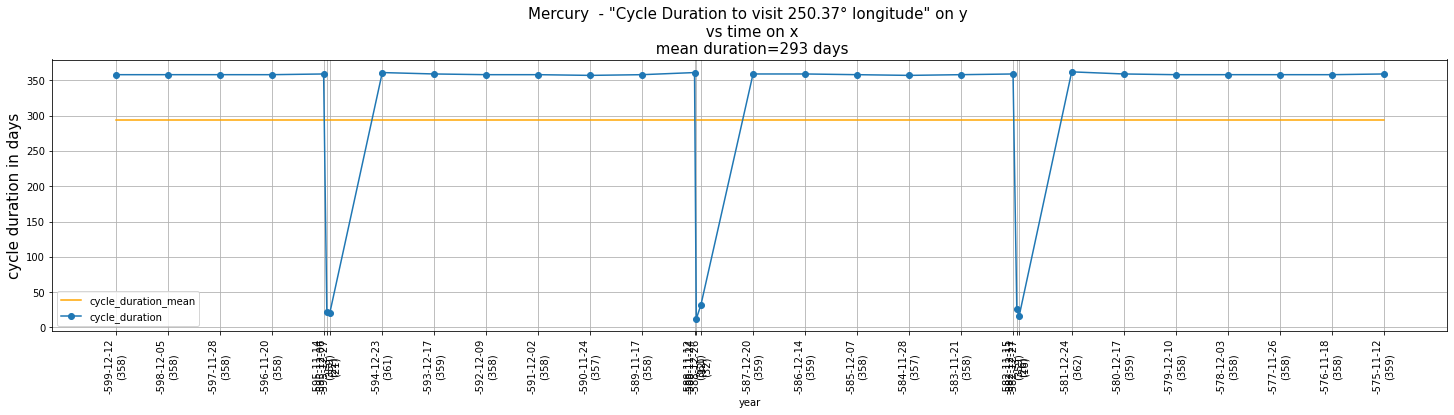

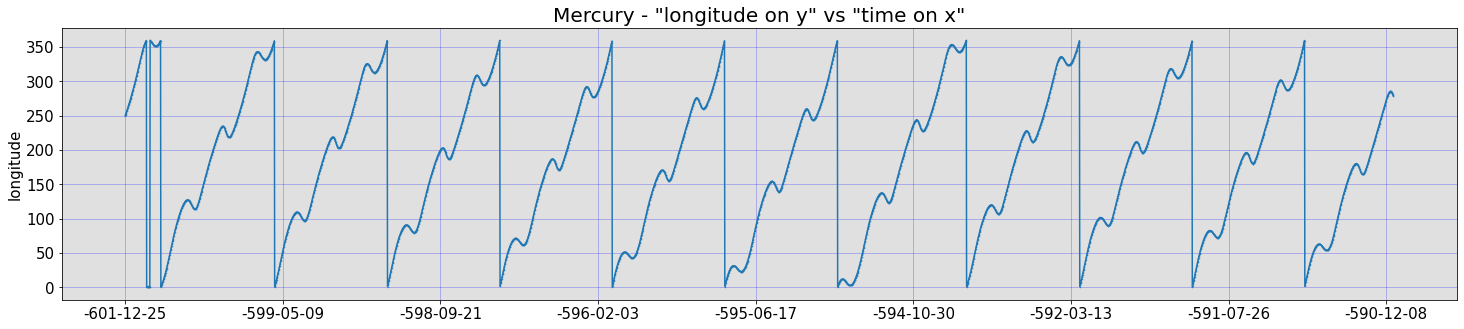

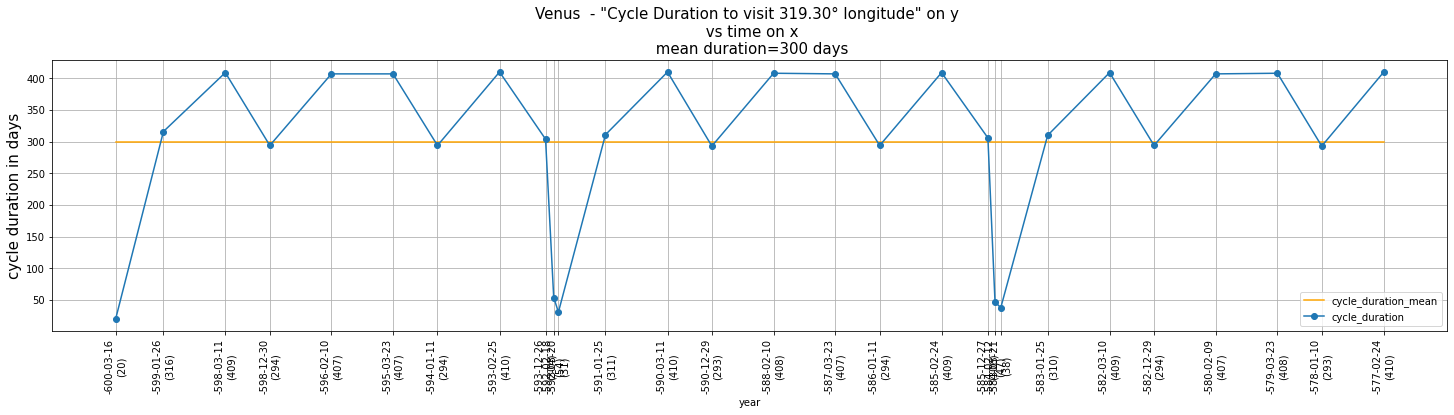

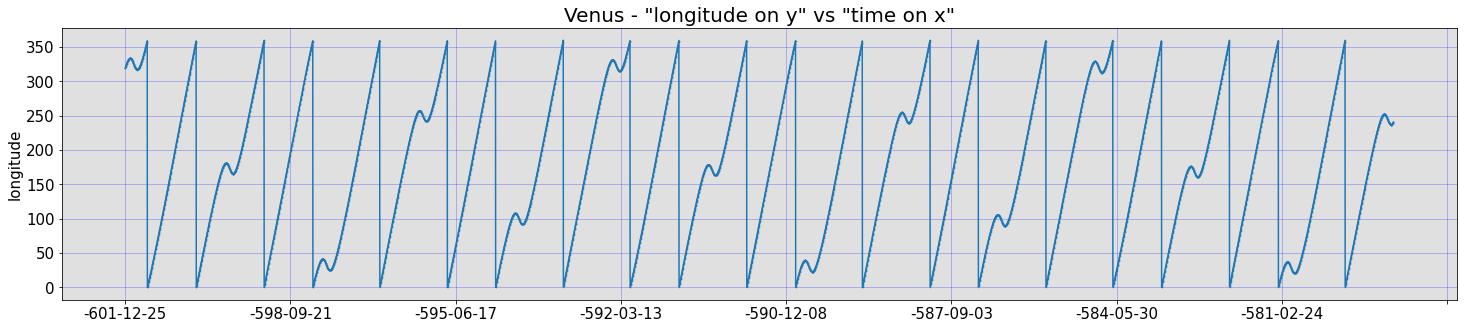

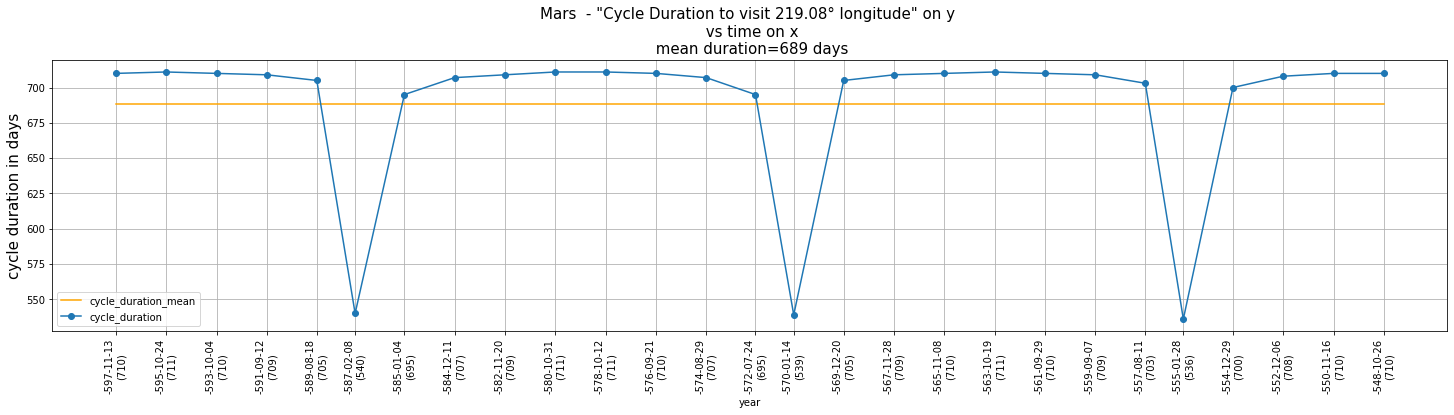

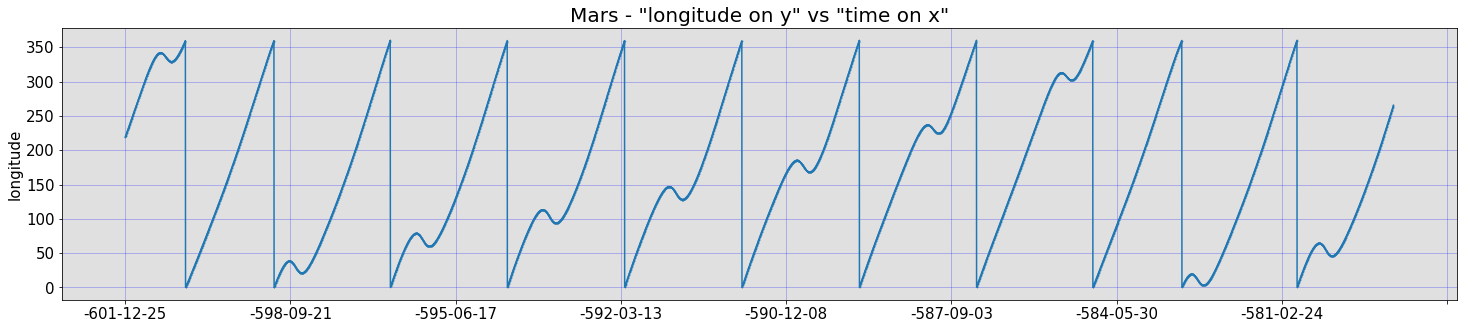

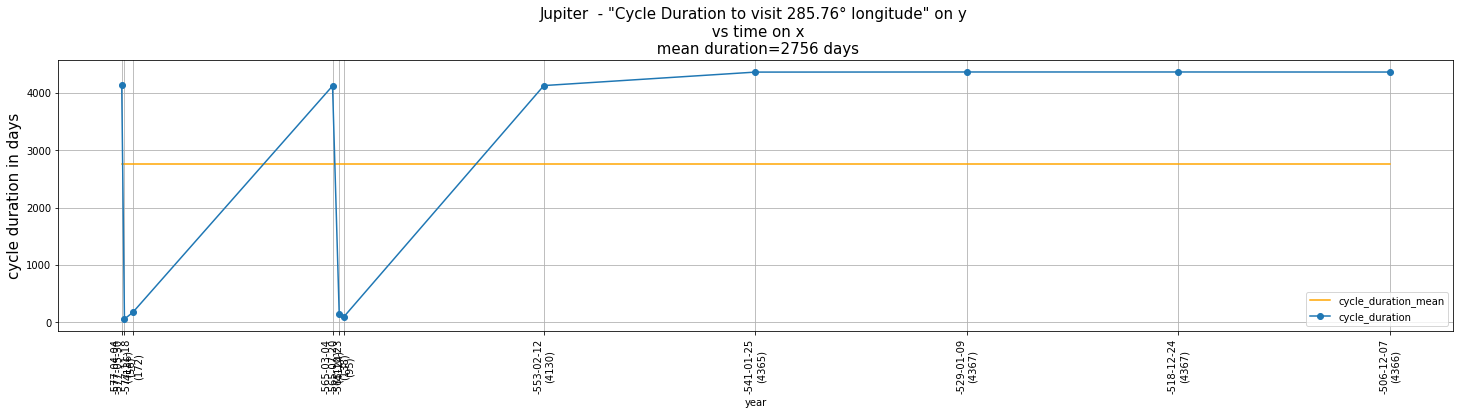

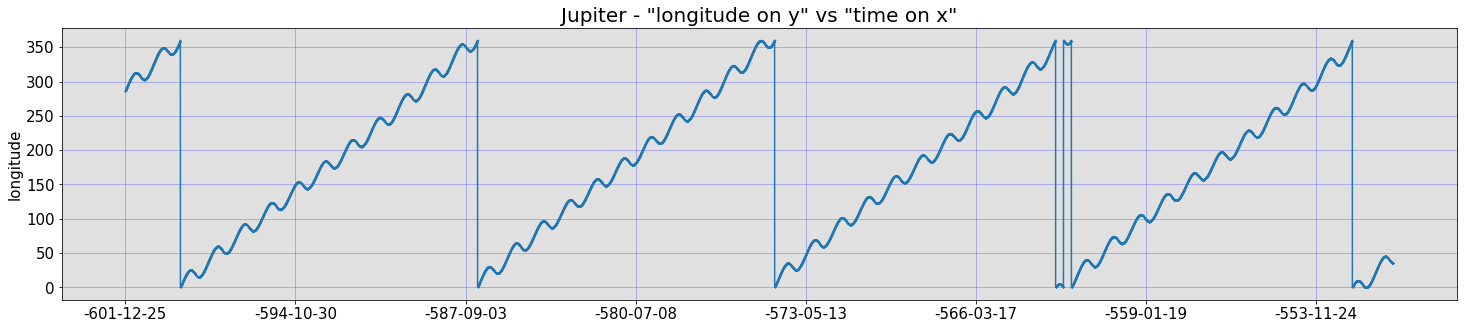

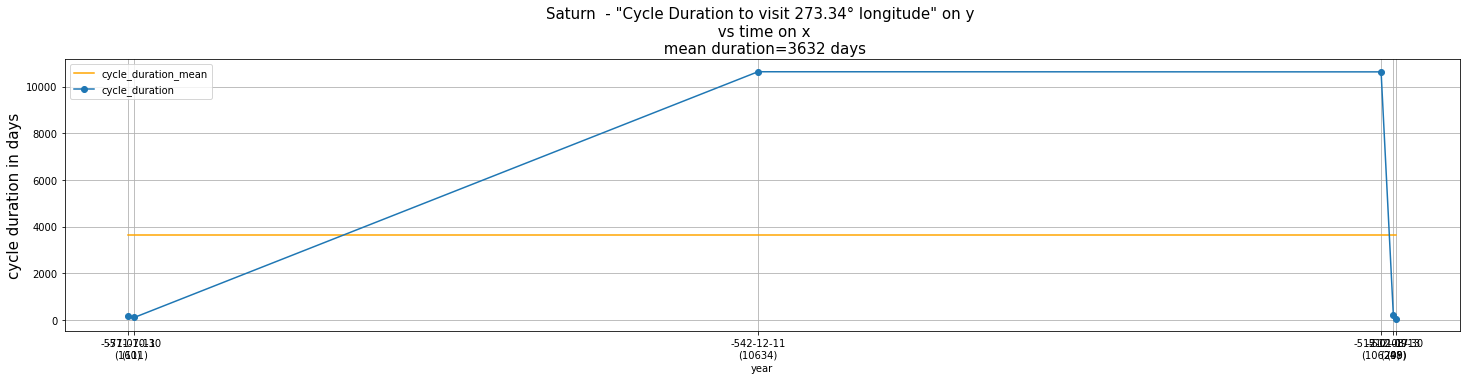

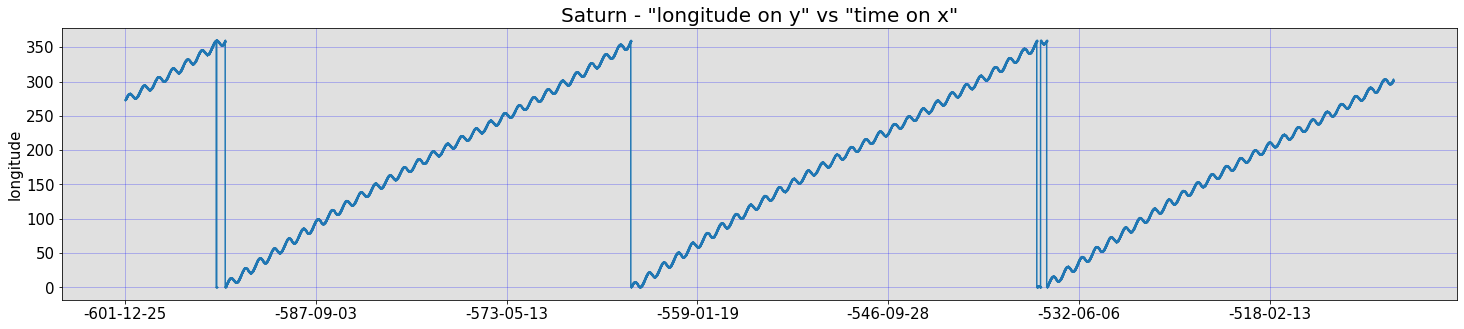

In [3]:

for g, limit, thr, tol, yr in zip(
		['mercury'] + ['venus', 'mars',] + ['jupiter', 'saturn'] , 
		[.25, .25 , .5, None, None],
		[120, 120,120, 190, 220],
		[.8, .8, .8, .5, .05],
		[-590, -580, -580, -550, -510] ):
	gdf = fetch_gruha_df(gruha=g)
	plot_gruha_near_naks(gdf, g, limit=limit, threshold=thr/thr, tol=tol, naks_lon=gdf.elong.iloc[0])
	plot_gruha_lon_vs_time(gdf, g, yr)

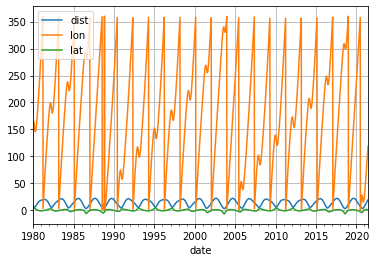

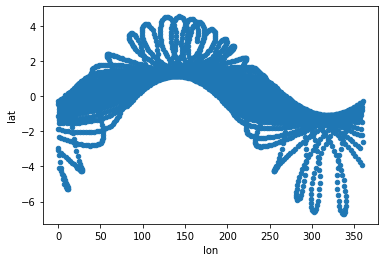

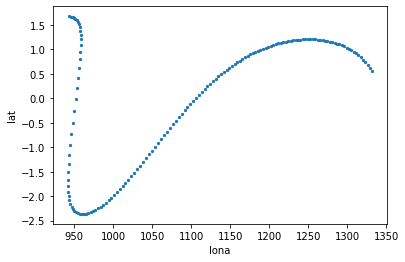

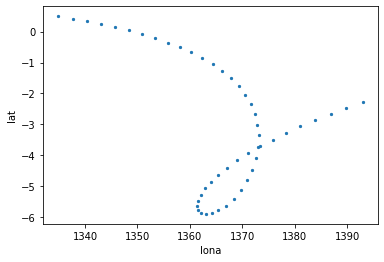

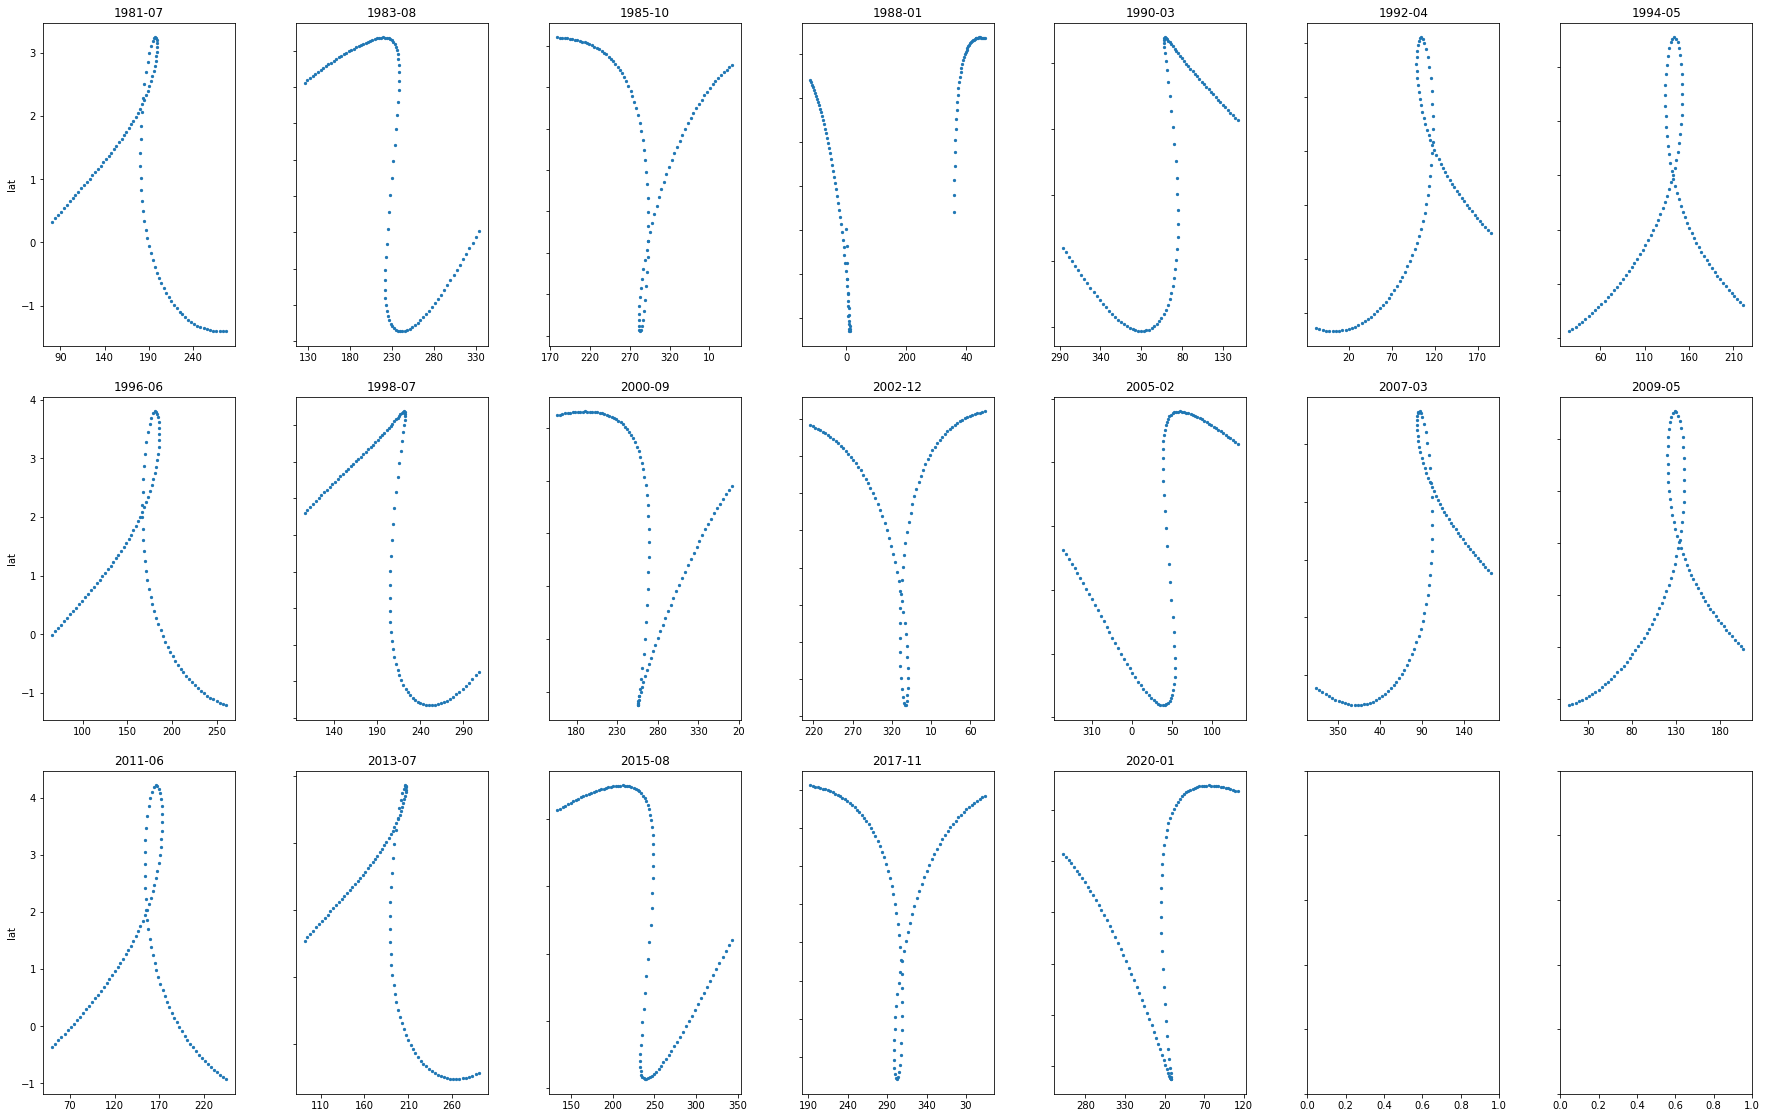

In [4]:

# dtypes = [str, str, float, float, float]
mr = pd.read_csv("../datasets/mars-retro.txt", sep="\t").drop(columns=['hhmm'])
mr.date = pd.to_datetime(mr.date)
mr = mr.set_index('date')
mr
ax = mr.plot()
_= ax.grid()
# %%

_ = mr.plot(kind='scatter', x="lon", y="lat")

# %%
f=0
ans =[]
for d ,l in zip(mr.lon.diff() , mr.lon) :
  if d < -300 : f+=1
  ans.append( l + f*360)

mr['lona'] = ans
_ = mr[300:450].plot(kind='scatter', x="lona", y="lat", marker='.')
# %%
_ = mr[450:500].plot(kind='scatter', x="lona", y="lat", marker='.')

# %%
mr['ldiff'] = mr.lon.diff()
mr['retro'] = mr.ldiff.apply( lambda x: 1 if x < -1 and x >-300 else 0)
mr1 = mr.reset_index()
mr1 = mr1[mr1.retro==1]
idx = pd.Series(mr1.index)
idxd = idx.diff()
idx[idxd>1].shape

#%%
fig, axs = plt.subplots(3,7, figsize=(25,16))
fig.tight_layout(pad=3.0)
for span,ax in zip(idx[idxd>1], axs.flatten()) :
  mrx = mr[span-50:span+50]
  mrx.plot(ax=ax, kind='scatter', 
  x="lona", y="lat", marker='.', 
  sharey=True,
  title=re.sub(".\d\d\s00:00:00","",str(mrx.index[0]))) 
  ax.set_xlabel("")
  # ax.set_xticklabels([ t.get_text() for t in ax.get_xticklabels()])
  # print([ int(t%360) for t in ax.get_xticks()])
  _ = ax.set_xticklabels([ int(t%360) for t in ax.get_xticks()])

# %%


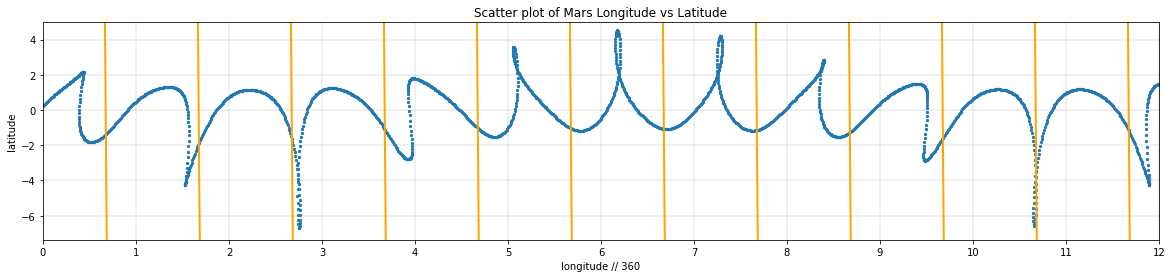

In [5]:
mr1= mr.reset_index()
ix = mr1[mr1.lon<5].index.values[7]
mr1=mr1.iloc[ix+720:ix+4600]
mr1['lonb'] = mr1.lona - mr1.lona.min()
m_ax = mr1.plot.scatter(x="lonb", y="lat", marker='.', figsize=(20,4))

m_ax.set_xticks(range(int(mr1.lonb.min()), int(mr1.lonb.max()), 360))
m_ax.set_xticklabels( [ int(t//360) for t in m_ax.get_xticks()])
m_ax.set_xlabel("longitude // 360")
m_ax.set_ylabel("latitude")
for i in range( -1, 13) :
    # m_ax.plot([240+i*360,240+i*360], [mr1.lonb.min(),mr1.lonb.max()], lw=2, color='orange')
    m_ax.plot([247+i*360,240+i*360], [mr1.lat.min()*1.1,mr1.lat.max()*1.1], lw=2, color='orange')

m_ax.set_title("Scatter plot of Mars Longitude vs Latitude")
m_ax.set_xlim(0,360*12)
m_ax.set_ylim(mr1.lat.min()*1.1,mr1.lat.max()*1.1)
m_ax.grid(color='gray', lw=.25)


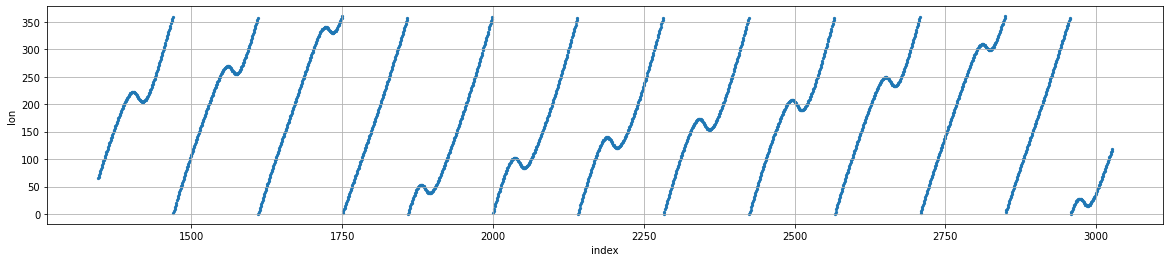

In [6]:
m_ax = mr1.reset_index().plot.scatter(x="index", y="lon", secondary_y = 'lat', marker='.', figsize=(20,4), grid=True)
# mr1.reset_index().plot(x="index", y="lat", marker='.', secondary_y=True, ax=m_ax, color='gray')

In [7]:
!rm ./gruha_chaara.html 2>/dev/null
!date
!`which jupyter` nbconvert gruha_chaara.ipynb --to html --no-input --output  gruha_chaara.html 2>&1 | tee ~/tmp/nbconvert.log
!open ./gruha_chaara.html

Tue Dec 12 10:53:03 IST 2023
Traceback (most recent call last):
  File "/Users/sunder/miniforge3/envs/tfmetal/bin/jupyter-nbconvert", line 5, in <module>
    from nbconvert.nbconvertapp import main
  File "/Users/sunder/miniforge3/envs/tfmetal/lib/python3.9/site-packages/nbconvert/__init__.py", line 7, in <module>
    from .exporters import *
  File "/Users/sunder/miniforge3/envs/tfmetal/lib/python3.9/site-packages/nbconvert/exporters/__init__.py", line 4, in <module>
    from .html import HTMLExporter
  File "/Users/sunder/miniforge3/envs/tfmetal/lib/python3.9/site-packages/nbconvert/exporters/html.py", line 26, in <module>
    from nbconvert.filters.markdown_mistune import IPythonRenderer, MarkdownWithMath
  File "/Users/sunder/miniforge3/envs/tfmetal/lib/python3.9/site-packages/nbconvert/filters/markdown_mistune.py", line 24, in <module>
    from mistune import PLUGINS, BlockParser, HTMLRenderer, InlineParser, Markdown
ImportError: cannot import name 'PLUGINS' from 'mistune' (/Users

In [8]:
mr

,dist,lon,lat,lona,ldiff,retro
date,,,,,,
1980-01-01,8.040461,163.971307,3.129889,163.971307,NaN,0
1980-01-06,7.696647,164.708064,3.290195,164.708064,0.736757,0
1980-01-11,7.366089,165.174530,3.453667,165.174530,0.466466,0
1980-01-16,7.052242,165.346125,3.617850,165.346125,0.171594,0
1980-01-21,6.759171,165.201842,3.779334,165.201842,-0.144283,0
...,...,...,...,...,...,...
2021-05-20,18.027259,106.148454,1.398979,8386.148454,3.057851,0
2021-05-25,18.325147,109.210020,1.383756,8389.210020,3.061567,0
2021-05-30,18.613022,112.275475,1.367485,8392.275475,3.065454,0


In [9]:

mr

,dist,lon,lat,lona,ldiff,retro
date,,,,,,
1980-01-01,8.040461,163.971307,3.129889,163.971307,NaN,0
1980-01-06,7.696647,164.708064,3.290195,164.708064,0.736757,0
1980-01-11,7.366089,165.174530,3.453667,165.174530,0.466466,0
1980-01-16,7.052242,165.346125,3.617850,165.346125,0.171594,0
1980-01-21,6.759171,165.201842,3.779334,165.201842,-0.144283,0
...,...,...,...,...,...,...
2021-05-20,18.027259,106.148454,1.398979,8386.148454,3.057851,0
2021-05-25,18.325147,109.210020,1.383756,8389.210020,3.061567,0
2021-05-30,18.613022,112.275475,1.367485,8392.275475,3.065454,0


In [ ]:
# mdf.apply ( lambda x: x.date.apply( lambda y: re.match("^(....)\-.*",y).groups()[0] ) , axis=1)
# yyyy = mdf.apply( lambda x: re.match("^(....)",x.date).groups(0)[0] , axis=1)
mdf.assign(
    zx1=mdf.date.apply( lambda x: int(re.match("^(....)",x).groups(0)[0]) ),
    # zx2=lambda x : x.zx1.apply( lambda y: y <= -600)
    zx2=lambda x : x.zx1 * x.zx1
    )

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()